## Load data

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
import warnings
import os
import sys
sys.path.append(os.path.abspath('..'))
warnings.filterwarnings("ignore")

In [3]:
from src.utils import load_df, save_df
from src.visualization import plot_target_distribution, plot_correlation_heatmap, plot_missing_data

In [ ]:
house_df = load_df("train-house-prices-advanced-regression-techniques.csv", "../data")
house_df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


## EDA

In [ ]:
house_df.shape

(1460, 81)

In [ ]:
house_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

Text(0.5, 1.0, 'Sales')

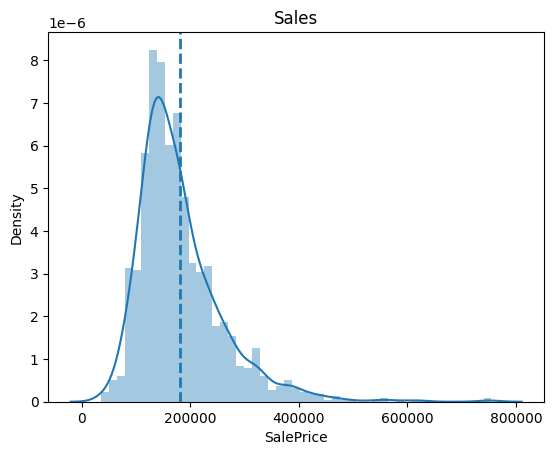

In [ ]:
# target variable
sns.distplot(house_df["SalePrice"])
plt.axvline(x=house_df["SalePrice"].mean(), linestyle="--", linewidth=2)
plt.title("Sales")

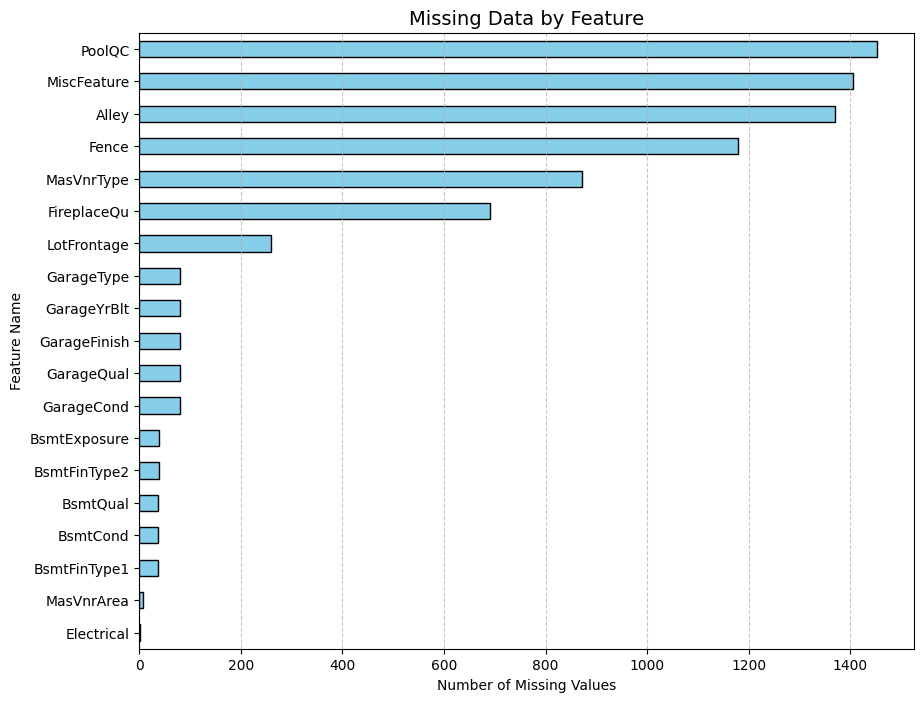

In [ ]:
# Checking missing values (horizontal view)
plot_missing_data(house_df)

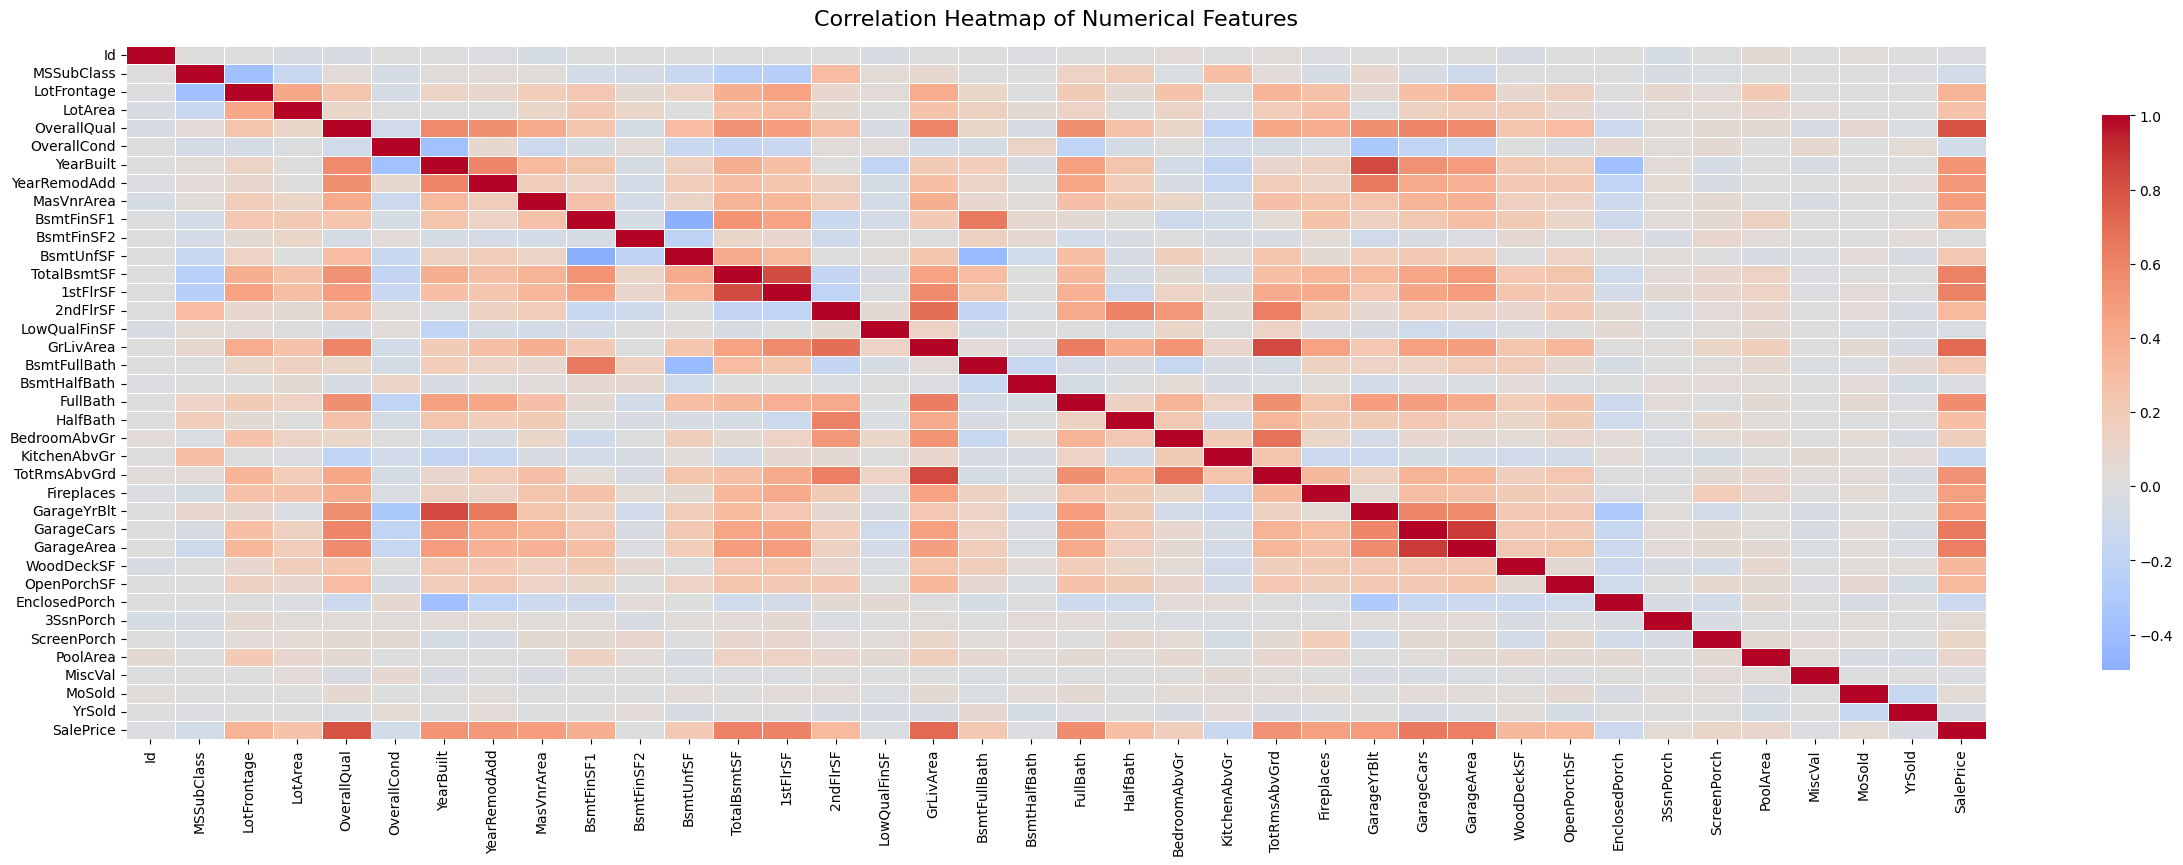

In [ ]:
plt.figure(figsize=(30, 9))
sns.heatmap(house_df.corr(numeric_only=True),
            cmap="coolwarm",
            linewidths=0.5,
            center=0,
            cbar_kws={"shrink": 0.8}
)
plt.title("Correlation Heatmap of Numerical Features", fontsize=16, pad=15)
plt.show()

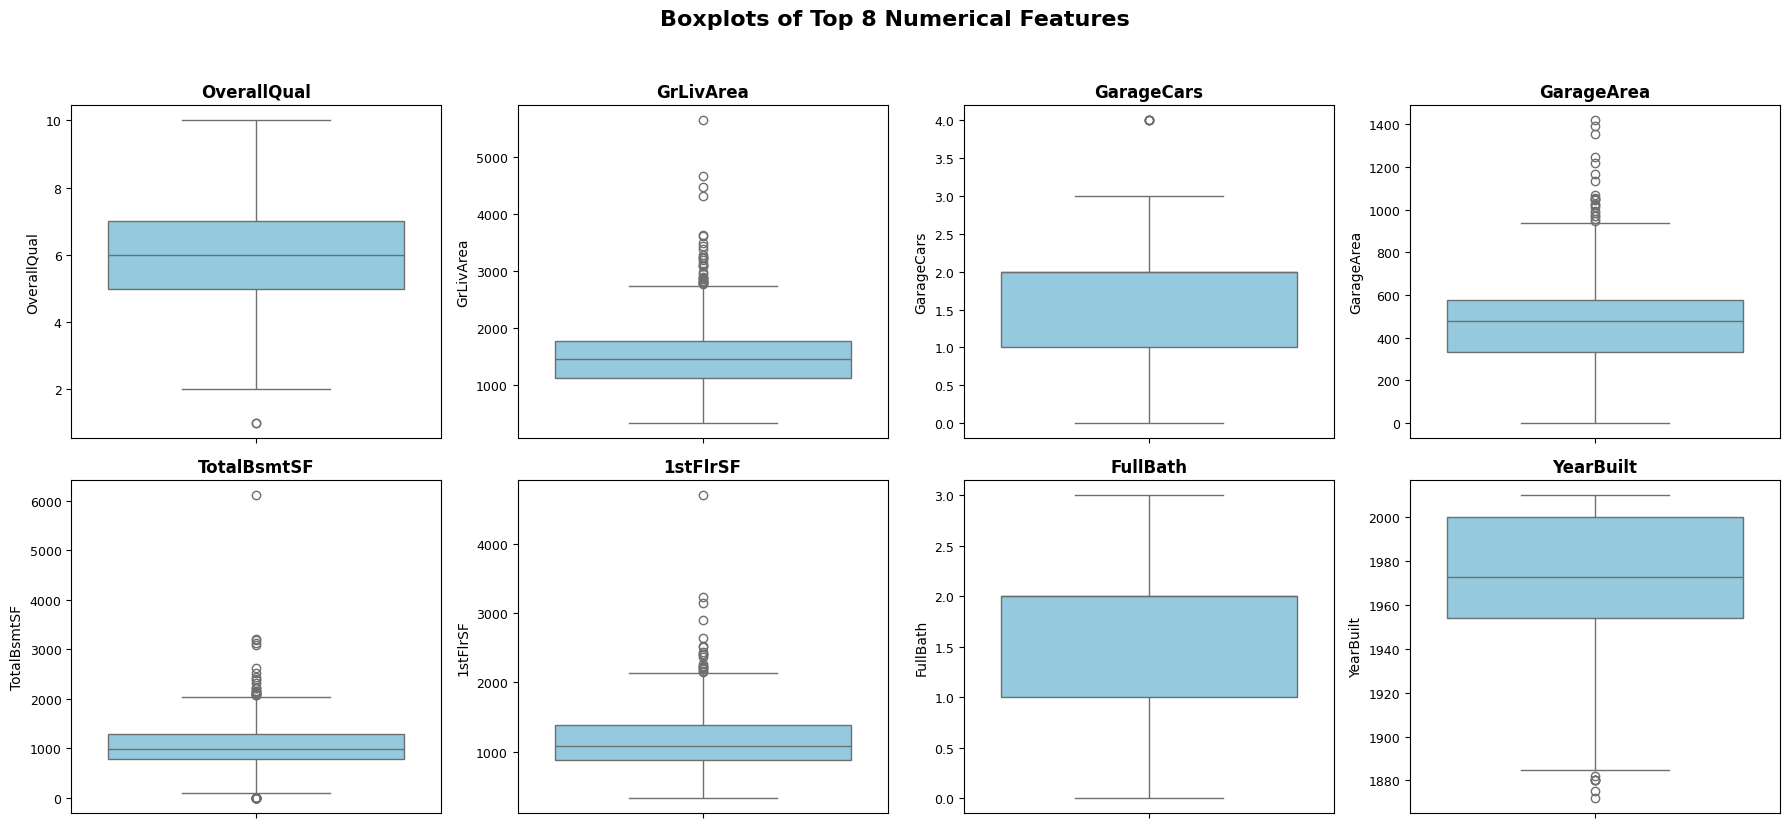

In [ ]:
# Chọn 8 đặc trưng numeric quan trọng nhất dựa trên tương quan với SalePrice
important_cols = [
    "OverallQual", "GrLivArea", "GarageCars", "GarageArea",
    "TotalBsmtSF", "1stFlrSF", "FullBath", "YearBuilt"
]

fig, axes = plt.subplots(2, 4, figsize=(18, 8))
axes = axes.flatten()

for i, col in enumerate(important_cols):
    sns.boxplot(data=house_df, y=col, ax=axes[i], color="skyblue")
    axes[i].set_title(col, fontsize=12, fontweight="bold")
    axes[i].tick_params(labelsize=9)

for i in range(len(important_cols), len(axes)):
    axes[i].set_visible(False)

plt.suptitle("Boxplots of Top 8 Numerical Features", fontsize=16, fontweight="bold", y=1.03)
plt.tight_layout()
plt.show()

## Preprocessing

In [ ]:
# droping values more than 50%
house_df_droped = house_df.drop(["Id","Alley","PoolQC","Fence","MiscFeature"], axis=1)

In [ ]:
# create training and validation sets
from sklearn.model_selection import train_test_split

train_df, test_df = train_test_split(
    house_df_droped,
    test_size=0.25,
    random_state=42
)

y_train = train_df["SalePrice"].values
y_test = test_df["SalePrice"].values
train_df = train_df.drop(["SalePrice"], axis=1)
test_df = test_df.drop(["SalePrice"], axis=1)
train_df.shape, test_df.shape

((1095, 75), (365, 75))

In [ ]:
num_cols = [col for col in train_df.columns if train_df[col].dtype in ["float64","int64"]]
cat_cols = [col for col in train_df.columns if train_df[col].dtype not in ["float64","int64"]]

In [ ]:
len(num_cols), len(cat_cols)

(36, 39)

In [ ]:
# fill none for categorical columns
train_df[cat_cols] = train_df[cat_cols].fillna("none")
test_df[cat_cols] = test_df[cat_cols].fillna("none")

In [ ]:
from sklearn.preprocessing import OneHotEncoder

# One-hot encode categorical columns

encoder = OneHotEncoder(handle_unknown="ignore", sparse_output=False)
encoder.fit(train_df[cat_cols])

encoded_cols = list(encoder.get_feature_names_out(cat_cols))

train_df[encoded_cols] = encoder.transform(train_df[cat_cols])
test_df[encoded_cols] = encoder.transform(test_df[cat_cols])

In [ ]:
from sklearn.impute import SimpleImputer

imputer = SimpleImputer() # Mean
train_df[num_cols] = imputer.fit_transform(train_df[num_cols])
test_df[num_cols] = imputer.transform(test_df[num_cols])

In [ ]:
train_df.shape

(1095, 75)

## Normalization

In [ ]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
train_num_features = scaler.fit_transform(train_df[num_cols])
test_num_features = scaler.transform(test_df[num_cols])

In [ ]:
X_train = np.hstack([train_num_features, train_df[encoded_cols].values])
X_test = np.hstack([test_num_features, test_df[encoded_cols].values])

In [ ]:
X_train.shape, y_train.shape

((1095, 282), (1095,))

In [ ]:
X_test.shape, y_test.shape

((365, 282), (365,))

## Training

### Basic Model

In [ ]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
import pandas as pd

# Tạo danh sách model
models = {
    'Linear' : LinearRegression(),
    'Rigde' : Ridge(),
    'Lasso' : Lasso()
}

# Khởi tạo list lưu kết quả
train_rmse_results = []
test_rmse_results = []
train_r2_results = []
test_r2_results = []
model_names = []

# Huấn luyện và tính metric
for name, model in models.items():
    regressor = model
    model.fit(X_train, y_train)

    # Dự đoán
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    # Tính RMSE
    train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
    test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))

    # Tính R²
    train_r2 = r2_score(y_train, y_train_pred)
    test_r2 = r2_score(y_test, y_test_pred)

    # Lưu kết quả
    model_names.append(name)
    train_rmse_results.append(train_rmse)
    test_rmse_results.append(test_rmse)
    train_r2_results.append(train_r2)
    test_r2_results.append(test_r2)

# Tạo DataFrame tổng hợp
df_results = pd.DataFrame({
    "Model": model_names,
    "Train_RMSE": train_rmse_results,
    "Test_RMSE": test_rmse_results,
    "Train_R2": train_r2_results,
    "Test_R2": test_r2_results
}).sort_values(by="Test_R2", ascending=False)

df_results


,Model,Train_RMSE,Test_RMSE,Train_R2,Test_R2
2,Lasso,20032.668558,26362.305805,0.933902,0.900794
0,Linear,20029.220254,28136.997313,0.933925,0.886987
1,Rigde,22488.286583,28587.343381,0.916705,0.883340


In [ ]:
lr = LinearRegression()
lr.fit(X_train, y_train)
coefs = pd.Series(lr.coef_)

# Lấy top 10 feature quan trọng nhất
top10 = coefs.abs().sort_values(ascending=False).head(30)

print("Top 10 features quan trọng nhất:")
print(top10)

Top 10 features quan trọng nhất:
120    592615.903416
98     184109.243214
2      142506.227944
252    132816.243891
122    132470.129196
8      127661.598277
11     124950.443839
258    122662.614036
15     103388.327911
126     97470.643859
125     93134.522621
123     90194.380712
124     90166.429973
121     89179.797055
12      86666.478712
13      84082.205130
96      63732.471598
3       63280.441797
255     62788.709267
32      60032.262069
95      57536.474990
233     57519.480649
119     54312.139781
134     52040.980278
21      51496.491639
97      49746.619032
5       48088.125174
100     45390.818394
184     44871.136072
26      44682.725669
dtype: float64


### Using polynomial

In [ ]:
from sklearn.preprocessing import PolynomialFeatures

poly_features = PolynomialFeatures(
    degree=2, interaction_only=True, include_bias=False
)

train_poly_features = poly_features.fit_transform(train_df[num_cols])
test_poly_features = poly_features.transform(test_df[num_cols])

In [ ]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
train_poly_features = scaler.fit_transform(train_poly_features)
test_poly_features = scaler.transform(test_poly_features)

In [ ]:
X_train_poly = np.hstack([train_poly_features, train_df[encoded_cols].values])
X_test_poly = np.hstack([test_poly_features, test_df[encoded_cols].values])

In [ ]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
import pandas as pd

# Tạo danh sách model
models = {
    'Linear' : LinearRegression(),
    'Rigde' : Ridge(),
    'Lasso' : Lasso()
}

# Khởi tạo list lưu kết quả
train_rmse_results = []
test_rmse_results = []
train_r2_results = []
test_r2_results = []
model_names = []

# Huấn luyện và tính metric
for name, model in models.items():
    regressor = model
    model.fit(X_train_poly, y_train)

    # Dự đoán
    y_train_pred = model.predict(X_train_poly)
    y_test_pred = model.predict(X_test_poly)

    # Tính RMSE
    train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
    test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))

    # Tính R²
    train_r2 = r2_score(y_train, y_train_pred)
    test_r2 = r2_score(y_test, y_test_pred)

    # Lưu kết quả
    model_names.append(name)
    train_rmse_results.append(train_rmse)
    test_rmse_results.append(test_rmse)
    train_r2_results.append(train_r2)
    test_r2_results.append(test_r2)

# Tạo DataFrame tổng hợp
df_results = pd.DataFrame({
    "Model": model_names,
    "Train_RMSE": train_rmse_results,
    "Test_RMSE": test_rmse_results,
    "Train_R2": train_r2_results,
    "Test_R2": test_r2_results
}).sort_values(by="Test_R2", ascending=False)

df_results


,Model,Train_RMSE,Test_RMSE,Train_R2,Test_R2
1,Rigde,16057.215172,27763.366559,0.957533,0.889969
2,Lasso,12063.654479,34402.874562,0.976030,0.831048
0,Linear,9545.514116,55032.412230,0.984993,0.567676


In [ ]:
df_results['Model'][0]

'Linear'

## Summary pipeline

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_squared_error, r2_score

# --------------------------------------------------
# 1️⃣ Chuẩn bị dữ liệu
# --------------------------------------------------
house_df_droped = house_df.drop(["Id", "Alley", "PoolQC", "Fence", "MiscFeature"], axis=1)

train_df, test_df = train_test_split(
    house_df_droped, test_size=0.25, random_state=42
)

y_train = train_df["SalePrice"].values
y_test = test_df["SalePrice"].values
train_df = train_df.drop(["SalePrice"], axis=1)
test_df = test_df.drop(["SalePrice"], axis=1)

num_cols = [col for col in train_df.columns if train_df[col].dtype in ["float64", "int64"]]
cat_cols = [col for col in train_df.columns if train_df[col].dtype not in ["float64", "int64"]]

# --------------------------------------------------
# 2️⃣ Xây dựng bộ tiền xử lý
# --------------------------------------------------

# Pipeline cho cột numeric
num_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', MinMaxScaler())
])

# Pipeline cho cột categorical
cat_pipeline = Pipeline(steps=[
    ('encoder', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

# Kết hợp vào ColumnTransformer
preprocessor = ColumnTransformer(transformers=[
    ('num', num_pipeline, num_cols),
    ('cat', cat_pipeline, cat_cols)
])

# --------------------------------------------------
# 3️⃣ Tạo danh sách model để thử nghiệm
# --------------------------------------------------
models = {
    'Linear': LinearRegression(),
    'Ridge': Ridge(),
    'Lasso': Lasso()
}

# --------------------------------------------------
# 4️⃣ Huấn luyện, đánh giá và lưu kết quả
# --------------------------------------------------
results = []

for name, model in models.items():
    # Pipeline hoàn chỉnh: preprocessing + model
    pipe = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('model', model)
    ])

    pipe.fit(train_df, y_train)

    y_train_pred = pipe.predict(train_df)
    y_test_pred = pipe.predict(test_df)

    train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
    test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
    train_r2 = r2_score(y_train, y_train_pred)
    test_r2 = r2_score(y_test, y_test_pred)

    results.append({
        'Model': name,
        'Train_RMSE': train_rmse,
        'Test_RMSE': test_rmse,
        'Train_R2': train_r2,
        'Test_R2': test_r2
    })

# --------------------------------------------------
# 5️⃣ Tổng hợp kết quả
# --------------------------------------------------
df_results = pd.DataFrame(results).sort_values(by="Test_R2", ascending=False)
print(df_results)

    Model    Train_RMSE     Test_RMSE  Train_R2   Test_R2
2   Lasso  20032.668558  26362.305805  0.933902  0.900794
0  Linear  20029.220254  28136.997313  0.933925  0.886987
1   Ridge  22488.286583  28587.343381  0.916705  0.883340
